In [1]:
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import numpy as np
import pandas as pd
from datetime import datetime as dt
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import os
import json
import netCDF4
import xarray as xr
import glob


import prop_data_prep as pdp
import prop_nn_models as pnn
import prop_nn_functions as pnf
import prop_MCDO_functions as MCDO
from prop_mms_data_prep import write_toDf, sweep

In [2]:
# load model
model_floc = "prop_models/"  # directory to save model
model_fname = "ANN_complete_a"  # model name
model_path = model_floc + model_fname # full model path

# load hyperparameter configuration
f = open(model_path + "_config.json")
CONFIG = json.load(f)

# load train/test dataset
df_ds = pd.read_pickle("prop_models/complete_training_df")

# initialize the model
model = pnn.FeedForwardNN_MCDO(CONFIG['num_features'], CONFIG['seq_len'], CONFIG['hidden_size'], CONFIG['output_size'], CONFIG['dropout_prob'])
model.load_state_dict(torch.load(model_floc + model_fname))

<All keys matched successfully>

In [3]:
df_ds.head(5)

,Dst,L,MLAT,Scpot,E_DIS_X,E_DIS_Y,E_DIS_Z,E_EDI_X,E_EDI_Y,E_EDI_Z,EX,EY,EZ,OMNI_IMF,OMNI_BY_GSE,OMNI_BZ_GSE,OMNI_Vx,OMNI_Vy,OMNI_Vz,OMNI_SYM_H
time,,,,,,,,,,,,,,,,,,,,
2015-09-01 00:08:00,-6.0,9.796476,-17.938861,4.262079,-0.291633,0.622727,-1.210110,-0.549219,0.289322,-0.751613,-0.442514,0.516338,-1.094584,71,-0.06,-1.09,-356.799988,-14.700000,11.0,-4
2015-09-01 00:09:00,-6.0,9.780545,-17.953911,4.308073,-0.744342,0.871588,-1.850324,-0.761078,0.595109,-1.364804,-0.784600,0.713652,-1.590373,71,-1.63,-0.86,-355.799988,-9.600000,10.1,-5
2015-09-01 00:10:00,-6.0,9.764557,-17.969014,4.298058,-0.070033,0.780695,-1.382092,-0.364863,0.492975,-1.005470,-0.082300,0.655852,-1.168116,71,-0.92,-0.73,-356.700012,-22.700001,14.9,-4
2015-09-01 09:45:00,-10.0,10.274726,-21.910362,3.278737,0.468317,0.126945,-0.288607,-0.073053,0.306335,-0.066902,0.455473,0.078034,-0.264601,71,-2.02,-4.41,-356.799988,-20.600000,-10.2,-2
2015-09-01 09:46:00,-10.0,10.297131,-21.937130,3.055708,0.268479,0.293626,-0.241045,0.328425,0.303209,-0.271164,0.290024,0.311502,-0.257547,71,-1.64,-4.50,-355.799988,-18.200001,-11.7,-2


Random seed set as 42


/Users/bisola/.virtualenvs/venv-imef/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


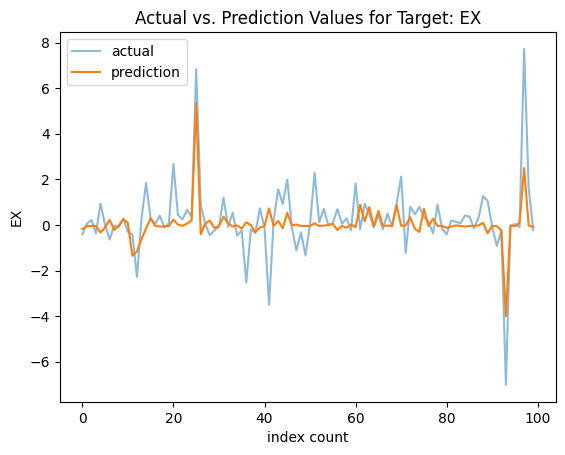

In [4]:
# # plot results
# preds = model(x_test_tensor).detach().numpy()

# MODEL SETUP 
predictors = ["OMNI_IMF","OMNI_Vx","OMNI_Vy","OMNI_Vz","OMNI_SYM_H","L","MLAT"] # predictors, features
target = ["EX", "EY", "EZ"]  # targets, outputs

# set a fixed value for the hash seed
seed=42
np.random.seed(seed)
random.seed(seed)
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
print(f"Random seed set as {seed}")

# (!) when running on the CuDNN backend, two further options must be set
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# define target and predictions variables
# x_train : feature vector (inputs) for training dataset
# y_train : target vector (outputs) for training dataset
# x_test : feature vector for testing dataset; used to evaluate models performace
# y_test : test vector for testing dataset

# during training, algorithm learns from x,y_train, adjusting to minimize error.
# performance is evaluated by x,y_test.

# split dataset into predictors (x) and target (y)
x = df_ds[predictors]
# x = df_ds[predictors].values # 5/10/24

if len(target) > 1:
    y = df_ds[target]
    # y = df_ds[target].values  # 5/10/24
    # unsure if need to add .values, results are a little different
else:
    y = df_ds[target].values.reshape(-1, 1) # for one target 

# scaling the dataset
# - (?) scale y?
# - (!) consider min/max scaler (see that one article)
x_scaler = StandardScaler()
x_scaler.fit(x.values)
x_scaled = x_scaler.transform(x)
# y_scaler = StandardScaler()
# y_scaler.fit(y.values)
y_scaled = y #y_scaler.transform(y)

# write as 3D arrays
x_scaled3d, y_scaled3d = pdp.prepare_3Darrs(x_scaled,y_scaled,lag=CONFIG['seq_len'],delay=1,next_steps=1)

# define train and test sets
#   - (!) always shuffling to best avoid cross-sampling
x_train, x_test, y_train, y_test = train_test_split(x_scaled3d, y_scaled3d, test_size=0.3, random_state=seed, shuffle=True)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=seed, shuffle=True) # test/validation set

# covert data to torch tensors
x_train_tensor = torch.Tensor(x_train)
y_train_tensor = torch.Tensor(y_train)
x_test_tensor = torch.Tensor(x_test)
y_test_tensor = torch.Tensor(y_test)
x_val_tensor = torch.Tensor(x_val)
y_val_tensor = torch.Tensor(y_val)

model.eval()
with torch.no_grad():

    preds = model(x_test_tensor).detach().numpy()
    # preds_descaled = y_scaler.inverse_transform(preds)
    # y_test_descaled = y_scaler.inverse_transform(y_test[:, -1, :])

    # y_out_inv = y_scaler.inverse_transform(preds)
    # y_test_inv = y_scaler.inverse_transform(y_test[:, 0])

    # for scaling
    ia = 1000
    ib = 1100

    # plot single target
    plt.plot(y_test[:,:,0][ia:ib], alpha=0.5, label="actual")
    plt.plot(preds[:, 0][ia:ib], label="prediction")
    # plt.plot(y_test_descaled[:,0][ia:ib], alpha=0.5, label="actual")
    # plt.plot(preds_descaled[:, 0][ia:ib], label="prediction")
    plt.title(f"Actual vs. Prediction Values for Target: {target[0]}")
    plt.xlabel(f"index count")
    plt.ylabel(f"{target[0]}")
    plt.legend()
    plt.show()
    plt.close()

    # # plot all targets
    # fig, axes = plt.subplots(len(target), 1)
    # for i in range(len(target)):
    #     axes[i].plot(y_test_descaled[:, i], alpha=0.5, label="actual")
    #     axes[i].plot(preds_descaled[:, i], alpha=0.5, label="prediction")
    #     axes[i].set_ylabel(target[i])
    #     axes[i].legend()

In [5]:
# evaluate on the test set (no MC dropout)
# set model to evaluation mode and deactivate autogradient engine
model.eval()
with torch.no_grad():
    predictions = model(x_test_tensor).detach().numpy()

    for i in range(CONFIG['output_size']):
        rmse = MCDO.rmse(y_test[:, 0, i], predictions[:, i])
        print(f"RMSE for {target[i]}: {rmse:.4f}")

RMSE for EX: 1.1792
RMSE for EY: 0.9471
RMSE for EZ: 0.7175


In [68]:
from hapiclient import hapi

# t0 = "2015-09-01T00:00:00"
# tf = "2022-08-31T23:59:00"

# data server
# server = "https://cdaweb.gsfc.nasa.gov/hapi"

# # OMNI 1-minute dataset
# dataset = "OMNI_HRO2_1MIN"

# # The HAPI convention is that parameters is a comma-separated list. Here we request two parameters.
# omni_parameters = "IMF, BY_GSE, BZ_GSE,Vx,Vy,Vz,SYM_H"

# # Configuration options for the hapi function.
# opts = {"logging": True, "usecache": True, "cachedir": "./hapicache"}

# # Get parameter data. See section 5 for for information on getting available datasets and parameters
# omni_data, meta = hapi(server, dataset, omni_parameters, t0, tf, **opts)

# COMBINE DATA

# # create df to hold combined mms and omni datasets
# complete_df = mms_df.copy()

# # get var names from OMNI data in format that can be indexed
# omni_names = [s.strip() for s in omni_parameters.split(",")]

# create omni df
# omni_df = df = pd.DataFrame()

# add time column
# omni_df['time'] = omni_data['Time']

# # add variables
# for var in omni_names:
#     complete_df["OMNI_" + var] = omni_data[var]

from pymms.data import fsm, fgm, scm, fpi, edi
import datetime as dt
from hapiclient import hapi

t0 = dt.datetime(2023, 4, 24, 16, 18, 0)
tf = dt.datetime(2023, 4, 25, 0, 0, 0)

def hapi_to_df(t0, tf):

    # create mother df
    df = pd.DataFrame()

    # %%% MMS data %%%

    # pull data using pymms
    mms_edi_data = edi.load_data(sc="mms1", mode="srvy", start_date=t0, end_date=tf)

    # # add time to df
    # df['mms_time'] = mms_edi_data["Epoch"]

    # # write mms data to df as individual coords
    # for xyz in ['x', 'y', 'z']:
    #     # add edi data to df
    #     df["E_DIS"+"_"+xyz.upper()] = mms_edi_data["E_GSE"].loc[:, "E"+xyz]

    # # average data into 1 min. bins
    # df = df.resample(rule="1Min", on="time").mean()

    # # # drop last row to account for OMNI dataset
    # mms_df = mms_df[:-1]

    # %%% OMNI data %%%

    # setup time in hapi input format
    t0_hapi = t0.strftime("%Y-%m-%d"+"T"+"%H:%M:%S")
    tf_hapi = tf.strftime("%Y-%m-%d" + "T" + "%H:%M:%S")
    print(t0_hapi) # check

    # hapi inputs
    server = "https://cdaweb.gsfc.nasa.gov/hapi"  # data server
    hapi_dataset = "OMNI_HRO2_1MIN"  # OMNI 1-minute dataset

    # params to download;
    #   - HAPI convention is that parameters is a comma-separated list
    omni_parameters = "IMF, BY_GSE, BZ_GSE,Vx,Vy,Vz,SYM_H" 

    # configuration options for the hapi function.
    opts = {"logging": True, "usecache": True, "cachedir": "./hapicache"}

    # pull omni data
    omni_data, meta = hapi(server, hapi_dataset, omni_parameters, t0_hapi, tf_hapi, **opts)

    # get var names from OMNI data in format that can be indexed
    omni_names = [s.strip() for s in omni_parameters.split(",")]

    # add omni data to df
    for var in omni_names:
        df["OMNI_" + var] = omni_data[var]

    # %%% CLEANING DATAFRAME %%%

    # OMNI velcotiy has erroneous data where Vxyz values ~99999.9; removing those
    omni_threshold = 90000
    df[df["OMNI_Vx"] >= omni_threshold] = np.nan

    # drop rows with nans
    df.dropna(axis=0, inplace=True)

    return df

df_om =  hapi_to_df(t0, tf)

df_om

# [BI:06/13/2024]

2023-04-24T16:18:00
hapi(): Running hapi.py version 0.2.6
hapi(): file directory = ./hapicache/cdaweb.gsfc.nasa.gov_hapi
hapi(): Reading OMNI_HRO2_1MIN_IMF,BY_GSE,BZ_GSE,Vx,Vy,Vz,SYM_H_20230424T161800_20230425T000000.pkl
hapi(): Reading OMNI_HRO2_1MIN_IMF,BY_GSE,BZ_GSE,Vx,Vy,Vz,SYM_H_20230424T161800_20230425T000000.npy 


,OMNI_IMF,OMNI_BY_GSE,OMNI_BZ_GSE,OMNI_Vx,OMNI_Vy,OMNI_Vz,OMNI_SYM_H
12,52.0,5.24,21.610001,-512.099976,56.700001,-39.200001,-89.0
13,52.0,4.82,21.700001,-512.099976,56.700001,-39.200001,-89.0
17,52.0,5.47,21.469999,-518.000000,71.500000,-29.500000,-87.0
18,52.0,5.37,21.469999,-518.000000,71.500000,-29.500000,-88.0
19,52.0,4.82,21.570000,-518.000000,71.500000,-29.500000,-88.0
...,...,...,...,...,...,...,...
456,52.0,5.15,9.060000,-496.100006,-15.900000,-16.900000,-63.0
457,52.0,4.94,9.370000,-496.100006,-15.900000,-16.900000,-63.0
458,52.0,4.87,9.410000,-496.100006,-15.900000,-16.900000,-63.0
460,52.0,4.84,8.930000,-487.799988,-4.100000,-13.600000,-59.0


In [57]:
t0 = dt.datetime(2023, 4, 23, 0, 0, 0)
tf = dt.datetime(2023, 4, 25, 0, 0, 0)
mms_data = edi.load_data(sc="mms1", mode="srvy", start_date=t0, end_date=tf)
edi_ey = mms_data["E_GSE"].loc[:,'Ey']
edi_ey

<xarray.DataArray 'E_GSE' (Epoch: 1119)>
array([-0.25197494,  0.13307509,  1.083172  , ...,  0.296054  ,
        0.4260477 ,  0.7469831 ], dtype=float32)
Coordinates:
  * Epoch    (Epoch) datetime64[ns] 2023-04-24T16:18:42.702129920 ... 2023-04...
    E_index  <U2 'Ey'
Attributes: (12/16)
    cdf_name:       mms1_edi_e_gse_srvy_l2
    cdf_type:       CDF_FLOAT
    rec_vary:       1
    CATDESC:        Electric field in GSE coordinates.
    DELTA_PLUS:     mms1_edi_e_gse_delta_plus_srvy_l2
    DELTA_MINUS:    mms1_edi_e_gse_delta_minus_srvy_l2
    ...             ...
    SCALETYP:       linear
    SI_CONVERSION:  1e-3>V/m
    units:          mV/m
    VALIDMIN:       -10000.0
    VALIDMAX:       10000.0
    VAR_TYPE:       data

In [ ]:
# get desired mms, omni data
#



In [ ]:
# # function to clean data
# def sweep(var, threshold=1000, cart=True, newtype=np.nan):

#     # extract x,y,z components if cart is true
#     if cart == True:
#         x_comp = var.loc[:, "x"].values  # x-component
#         y_comp = var.loc[:, "y"].values  # y-component
#         z_comp = var.loc[:, "z"].values  # z-component

#         # remove values above or eq. to threshold
#         for comp in [x_comp, y_comp, z_comp]:
#             comp[abs(comp) >= threshold] = newtype
#     else:
#         # remove values above or eq. to threshold
#         for comp in var.values:
#             comp[abs(comp) >= threshold] = newtype


# # function to find and filter outliers
# # (!) TBD


# # function to write given E-Field as dataframe
# def write_toDf(*args):

#     # create mother df
#     df = pd.DataFrame()

#     for var in args:
#         name = var.name  # get variable name
#         cart_check = (True if "cart" in var.dims else False)  # check if coords need to be extrapolated

#         if cart_check == True:
#             for axi in ["x", "y", "z"]:
#                 # append var coordinates to df
#                 df[name + "_" + axi.upper()] = var.loc[:, axi].values
#         else:
#             # append var to df
#             df[name] = var.values
            
#     return df

In [ ]:
# # LOCATE AND PULL MMS DATA

# # (*) glob module finds all pathnames given user-perscribed rules
# data_floc = "../mms-data/"  # directory for data file location
# dfile_mms1 = glob.glob(data_floc + "mms1*.nc")  # mms1 datafiles
# sample = "mms-data/mms1_imef_srvy_l2_5sec_20150901000000_20190101000000.nc"

# # open multiple files and load them along the time dimension
# #   - cache=False is required for lazy loading according to https://stackoverflow.com/a/45644654
# #   - decode_times=False is required for lazy loading according to https://stackoverflow.com/a/71158553
# #   - requires dask

# # open and combine datasets between 2015 to 2022 (mms1)
# #   - combine='nested' option indicates that the datasets should be combined along a new dimension
# #   - concat_dim='time' specifies the name of the new dimension
# mms_dataset = xr.open_mfdataset(
#     dfile_mms1,
#     combine="nested",
#     concat_dim="time",
# )

# instr = "E_DIS"  # instrument to bin
# coord = "x"  # cooridnate
# mlt_ang_adj = 1.0 / 24.0 * (2.0 * np.pi)  # MLT conversion


# time = mms_dataset["time"].values  # time data
# dis_dat = mms_dataset["E_DIS"].loc[:, coord].values  # pull EF data (DIS)
# edi_dat = mms_dataset["E_EDI"].loc[:, coord].values  # pull EF data (EDI)

# # write xarray data to pandas df
# mms_df = write_toDf(
#     mms_dataset["time"],
#     mms_dataset["Dst"],
#     mms_dataset["L"],
#     mms_dataset["MLAT"],
#     mms_dataset["Scpot"],
#     mms_dataset["E_DIS"],
#     mms_dataset["E_EDI"],
# )

# # combine datasets; replace NaN EDI data with DIS data, if exists
# coords = ["X", "Y", "Z"]
# for xyz in coords:
#     mms_df["E" + xyz] = mms_df["E_EDI_" + xyz].combine_first(mms_df["E_DIS_" + xyz])

# # CLEANUP

# # average data into 1 min. bins
# mms_df = mms_df.resample(rule="1Min", on="time").mean()

# # # drop last row to account for OMNI dataset
# mms_df = mms_df[:-1]

# # check
# mms_df.head(5)

In [ ]:
mms_df.index[-1]

NameError: name 'mms_df' is not defined

In [ ]:
# # GET OMNIWEB DATA
# # (using hapi)
# from hapiclient import hapi

# # data server
# server = "https://cdaweb.gsfc.nasa.gov/hapi" 

# # OMNI 1-minute dataset
# dataset = "OMNI_HRO2_1MIN"

# # pull start and stop times from MMS
# #   - done manually by copy-pasting index, will eventually want it to
# #       computationally pull time from the mms dataset
# #   - added extra minute so hapi times include final timestamp
# # combined_data.index[0]    >>Timestamp('2015-09-01 00:00:00')
# # combined_data.index[-1]   >>Timestamp('2022-08-31 23:59:00')

# t0 = "2015-09-01T00:00:00"
# tf = "2022-08-31T23:59:00"

# # The HAPI convention is that parameters is a comma-separated list. Here we request two parameters.
# omni_parameters = "IMF,Vx,Vy,Vz,SYM_H"

# # Configuration options for the hapi function.
# opts = {"logging": True, "usecache": True, "cachedir": "./hapicache"}

# # Get parameter data. See section 5 for for information on getting available datasets and parameters
# omni_data, meta = hapi(server, dataset, omni_parameters, t0, tf, **opts)

# # plot all parameters
# # from hapiplot import hapiplot
# # hapiplot(data, meta)

# #  check
# omni_data

hapi(): Running hapi.py version 0.2.6
hapi(): file directory = ./hapicache/cdaweb.gsfc.nasa.gov_hapi
hapi(): Reading OMNI_HRO2_1MIN_IMF,Vx,Vy,Vz,SYM_H_20150901T000000_20220831T235900.pkl
hapi(): Reading OMNI_HRO2_1MIN_IMF,Vx,Vy,Vz,SYM_H_20150901T000000_20220831T235900.npy 


array([(b'2015-09-01T00:00:00.000Z', 71, -366.1000061 , -22.5       ,  9.60000038,  -6),
       (b'2015-09-01T00:01:00.000Z', 71, -361.5       ,  -8.60000038,  4.5999999 ,  -5),
       (b'2015-09-01T00:02:00.000Z', 71, -360.70001221,  -6.4000001 ,  5.5999999 ,  -5),
       ...,
       (b'2022-08-31T23:56:00.000Z', 52, -499.6000061 , -44.        ,  0.        , -14),
       (b'2022-08-31T23:57:00.000Z', 52, -496.5       , -46.09999847, -3.70000005, -14),
       (b'2022-08-31T23:58:00.000Z', 52, -496.1000061 , -45.90000153, -3.4000001 , -14)],
      dtype=[('Time', 'S24'), ('IMF', '<i4'), ('Vx', '<f8'), ('Vy', '<f8'), ('Vz', '<f8'), ('SYM_H', '<i4')])

In [ ]:
# # create df to hold combined mms and omni datasets

# complete_df = mms_df.copy()

# # get var names from OMNI data in format that can be indexed
# omni_names = [s.strip() for s in omni_parameters.split(",")]

# # create omni df
# # omni_df = df = pd.DataFrame()

# # add time column
# # omni_df['time'] = omni_data['Time']

# # add variables
# for var in omni_names:
#     complete_df["OMNI_"+var] = omni_data[var]

# complete_df

,Dst,L,MLAT,Scpot,E_DIS_X,E_DIS_Y,E_DIS_Z,E_EDI_X,E_EDI_Y,E_EDI_Z,EX,EY,EZ,OMNI_IMF,OMNI_Vx,OMNI_Vy,OMNI_Vz,OMNI_SYM_H
time,,,,,,,,,,,,,,,,,,
2015-09-01 00:00:00,-6.0,9.921915,-17.820420,3.941119,-1.113431,1.075539,-2.337102,NaN,NaN,NaN,-1.113431,1.075539,-2.337102,71,-366.100006,-22.500000,9.6,-6
2015-09-01 00:01:00,-6.0,9.906427,-17.835027,3.978966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71,-361.500000,-8.600000,4.6,-5
2015-09-01 00:02:00,-6.0,9.890886,-17.849693,4.302952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71,-360.700012,-6.400000,5.6,-5
2015-09-01 00:03:00,-6.0,9.875289,-17.864415,4.361357,NaN,NaN,NaN,-1.136957,0.770519,-1.872842,-1.136957,0.770519,-1.872842,71,-361.399994,-6.100000,3.5,-5
2015-09-01 00:04:00,-6.0,9.859638,-17.879194,4.264417,NaN,NaN,NaN,-0.088993,0.524761,-0.951036,-0.088993,0.524761,-0.951036,71,-358.000000,-14.700000,8.9,-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31 23:54:00,-11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52,-495.399994,-42.500000,4.8,-14
2022-08-31 23:55:00,-11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52,-499.600006,-44.000000,0.0,-14
2022-08-31 23:56:00,-11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52,-499.600006,-44.000000,0.0,-14
